In [62]:
import pandas as pd
import numpy as np
import math 
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

from scipy.stats import mode
from datetime import timedelta

print("started")

started


In [36]:

from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier, XGBRegressor

mcc_bad_codes= [7801, 7802, 7994, 7995, 7800, 6300, 5960, 6010 ,6011, 6012 ,6211 ,6529, 6530 ,5933 , 4829, 6532, 6533, 6534, 6536, 6537, 6538,6540 , 6050,6051, 4900,4812,4814,9222,7276, 9311]

def mode_count(x):
    return mode(x)[1][0][1]

In [4]:
#import currencies 
data = pd.read_csv("/home/lookuut/Projects/spark-sbt/resource/USD_RUR.csv")
data['day'] =  pd.to_datetime(data['DATE'], format = '%Y-%m-%d')
data['day'] = data['day'].apply(lambda x : math.floor((x.timestamp() / (3600 * 24))))
usd_rur = data[['day', 'WAPRICE']].set_index('day')['WAPRICE']

data = pd.read_csv("/home/lookuut/Projects/spark-sbt/resource/EUR_RUR.csv")

data['WAPRICE'] = data.apply(lambda row : row['OPEN'] if math.isnan(row['WAPRICE']) else row['WAPRICE'], axis = 1)
data['day'] =  pd.to_datetime(data['DATE'], format = '%Y-%m-%d')
data['day'] = data['day'].apply(lambda x : math.floor((x.timestamp() / (3600 * 24))))
eur_rur = data[['day', 'WAPRICE']].set_index('day')['WAPRICE']

In [5]:
usd_currency_type = 840
eur_currency_type = 978

currencies = [810, 978, 840, 784]
to_usd_currencies = {704 : 0.000045, 360 : 0.000074, 410 : 0.000892, 170 : 0.00035, 933 : 0.5}
max_day_number = 100

period_parts = [2, 4, 8, 16, 32, 64, 128]
max_period_day = 128
in_operations = ['DEPOSIT', 'C2C_IN', 'BACK_TRX']

def amount_with_currency(date, currency, amount) :
    
    if (currency in to_usd_currencies) : 
        amount = amount * to_usd_currencies[currency]
        currency = usd_currency_type
        
    if (not(currency == usd_currency_type or currency == eur_currency_type)) : 
        return amount
    
    day = math.floor(date.timestamp() / (24 * 3600))
    rates = {}
    if(currency == usd_currency_type) :
        rates = usd_rur 
    else :
        rates = eur_rur

    for x in range(0, 10, 1) :
        if (day - x in rates) :
            return amount * rates[day - x]
    amount

def get_day_diff(day_number, index, days) :
    diff = 0
    if (index == 0) :
        return 0

    if (day_number <= days[index - 1]) : 
        return 0


    return day_number - days[index - 1]

def get_day_part(hour) : 
    
    if (hour >= 0 and hour <= 8) : 
        return 1
    elif(hour > 8 and hour <= 18) : 
        return 2
    
    return 0

def apply_dataset (row) :
    datetime = pd.to_datetime(row['TRDATETIME'], format = '%d%b%y:%X')
    pd.Series({'hour': datetime.hour})
    

In [38]:
holydays = ['2016-10-04','2016-10-05','2016-10-06','2016-12-31',
            '2017-01-01','2017-01-02','2017-01-03','2017-01-04','2017-01-05','2017-01-06','2017-01-07','2017-01-08',
            '2017-02-23','2017-02-24','2017-02-25','2017-02-26',
            '2017-03-08',
            '2017-04-29','2017-04-30','2017-05-01',
            '2017-05-06','2017-05-07','2017-05-08','2017-05-09',
            '2017-06-10','2017-06-11','2017-06-12',
            '2017-11-03','2017-11-06','2017-11-07','2017-11-08',
            '2017-12-30','2017-12-31',
            '2018-01-01','2018-01-02','2018-01-03','2018-01-04','2018-01-05','2018-01-06','2018-01-07','2018-01-08',
            '2018-02-23','2018-02-24','2018-02-25',
            '2018-03-08','2018-03-09','2018-03-10','2018-03-11'
           ]

holydays = pd.to_datetime(holydays, format = '%Y-%m-%d')
holydays = holydays.map(lambda x : int(math.floor(x.timestamp() / (24 * 3600))))
ostatok_cols = ['ostatok_1' , 'ostatok_10', 'ostatok_100', 'ostatok_1000']


In [153]:
%%time

import requests
import datetime

mcc_bad_codes= [7801, 7802, 7994, 7995, 7800, 6300, 5960, 6010 ,6011, 6012 ,6211 ,6529, 6530 ,5933 , 4829, 6532, 6533, 6534, 6536, 6537, 6538,6540 , 6050,6051, 4900,4812,4814,9222,7276, 9311]
trash_mcc = [1468,7531,5451,4011,8071,7278,5111,9211,7032,7375,3010,7699,780,5970,3703,4411,5131,7392,3381,5733,5310,3355,5199,3260,3607,3824,3515,3628,3387,3057,3058,7629,7998,3503,3642,7393,3013,7349,5074,7210,5122,7841,5039,3047,2741,4582,5172,5065,3509,3357,5817,5931,5085,5976,7297,7394,3136,3502,8244,7993,1750,3008,5521,5968,3501,3533,8641,3236,7911,5169,5967,6513,5969,7261,5971,5973,5094,1711,7829,8911,5718,8351,3504,7372,8931,3586,3553,5998,7932,3640,7929,1799,7217,5940,3005,3535,3674,7321,3032,3102,5818,7338,3068,3297,3393,3042,3665,3604,5697,7992,5137,5978,5932,5099,3579,7339,5047,3710,3405,9405,5561,5599,8661,3778,7251,7622,3245,5072,8111,3246,7033,3026,3077,8220,3530,4225,3000,3007,2842,3715,8042,7273,5571,5972,3029,3182,7549,8699,8241,8050,7631,3750,3555,763,3583,3625,3508,3722,5046,3692,7379,5551,5139,3615,7623,3590,7277,3545,5198,1731,5937,3690,3001,3395,7333,3028,3191,3035,1520,3217,3181,5996,3512,3064,3543,3513,4457,7534,5962,5963,3211,7211,3659,5815,3548,3098,3655,3559,5965,5021,5051,3678,3650,7519,3015,3520,3051,8675,5997,7012,3634,3730]

def load_dataset(name):
    data = pd.read_csv(
        name 
    )
    
    data['TRDATETIME'] = pd.to_datetime(data['TRDATETIME'], format = '%d%b%y:%X')
    data['tr_hour'] = data.TRDATETIME.apply(lambda x : x.hour)
    data['day_part'] = data.tr_hour.apply(get_day_part)
    data['channel_type'] = data['channel_type'].fillna('0').apply(lambda s : int(s[-1]))
    data['cat_index'] = data.trx_category.astype('category').cat.codes
    data['period_month'] = pd.to_datetime(data['PERIOD'], format = '%d/%m/%Y').apply(lambda x : x.year * 12 + x.month)
    data['week_day'] = data.TRDATETIME.apply(lambda dt : dt.weekday())
    data['week_global_number'] = data.TRDATETIME.apply(lambda dt : math.floor(math.floor((dt.timestamp() / (3600 * 24))) / 7))
    data['quartel'] = data.TRDATETIME.apply(lambda dt : math.floor((dt.month - 1) / 3))
    data['amount'] = data.apply(lambda row : amount_with_currency(row['TRDATETIME'], row['currency'], row['amount']) , axis = 1)
    data['global_day_number'] = data.TRDATETIME.apply(lambda x : math.floor(x.timestamp() / (3600 * 24)))
    data['is_holiday'] = data.global_day_number.apply(lambda day: 1 if (day in holydays) else 0)
    data['month'] = data.TRDATETIME.apply(lambda dt : dt.month)
    data['day'] = data.TRDATETIME.apply(lambda dt : dt.day)
    data['year'] = data.TRDATETIME.apply(lambda dt : dt.year)
    
    minMonth = data.groupby('cl_id').max()['period_month'].to_dict()
    minWeekNumber = data.groupby('cl_id').min()['week_global_number'].to_dict()
    minDayNumber = data.groupby('cl_id').min()['global_day_number'].to_dict()
    
    data['min_month'] = data['cl_id'].apply(lambda x : minMonth[x])
    data['min_week_number'] = data['cl_id'].apply(lambda x : minWeekNumber[x])
    data['month_number'] = data.apply(lambda row : row['period_month'] - row['min_month'], axis=1)
    data['week_number'] = data.apply(lambda row : row['week_global_number'] - row['min_week_number'], axis=1)
    data['day_number'] = data.apply(lambda row : row['global_day_number'] - minDayNumber[row['cl_id']], axis=1)
    
    for period_part in period_parts : 
        data['period_part_%s' % period_part] = data.day_number.apply(lambda day : int(math.floor((day + 1) / period_part)) )
        
    data = data.sort_values(by=['cl_id', 'day_number'])
    data = data.reset_index(drop = True)
    days = data[['day_number']].to_dict()['day_number']

    data['day_diff'] = data.apply(lambda row : get_day_diff(row['day_number'], row.name, days) , axis = 1) 
    ##################################################################
    data['days_since2015'] = (data['TRDATETIME'] - pd.to_datetime('2015-01-01')).dt.days
    data['month'] = data['TRDATETIME'].dt.month + (data['TRDATETIME'].dt.year-2016)*12
    
    ostatok_cols = []
    for i in [1,10,100,1000]:
        new_col = 'ostatok_' + str(i)
        ostatok_cols.append(new_col)
        data[new_col] = ((data['amount'] % i) == 0)*1
    
    data['amount'] = -data['amount']
    ind = (data['trx_category']=='C2C_IN') | (data['trx_category']=='DEPOSIT') | (data['trx_category']=='BACK_TRX')
    data['amount'][ind] = abs(data['amount'][ind])
    data['channel_type'] = data['channel_type'].fillna('type0')
    
    return data

train = load_dataset('/home/lookuut/Projects/spark-sbt/resource/train.csv')
test = load_dataset('/home/lookuut/Projects/spark-sbt/resource/test.csv')

/home/lookuut/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 7min 15s, sys: 3.03 s, total: 7min 18s
Wall time: 7min 18s


# new features

In [101]:
#all data stats для подсчетов стандартного отклонения
all_data = pd.concat([train.drop(['target_flag','target_sum'],axis=1),test], axis=0).reset_index(drop=True)
all_data = all_data.sort_values(by='TRDATETIME').reset_index(drop=True)

In [102]:
def uniq_len(x):
    return len(set(x))

deliv_cards = all_data[['cl_id','PERIOD']].groupby('PERIOD').agg(['count',uniq_len]).reset_index()
deliv_cards['PERIOD'] = pd.to_datetime(deliv_cards['PERIOD'], format='%d/%m/%Y')
deliv_cards.columns = ['TRDATETIME', 'num_deals_month', 'uniq_len_num_cards']
deliv_cards['TRDATETIME'] = deliv_cards['TRDATETIME'].dt.month + (deliv_cards['TRDATETIME'].dt.year-2016)*12
deliv_cards['avg_act'] = deliv_cards['num_deals_month'] / deliv_cards['uniq_len_num_cards']
deliv_cards.head(15)

,TRDATETIME,num_deals_month,uniq_len_num_cards,avg_act
0,13,94631,3249,29.126193
1,25,6075,270,22.500000
2,14,77862,3212,24.240971
3,26,5659,243,23.288066
4,15,70850,2951,24.008811
5,27,5396,186,29.010753
6,16,88131,2886,30.537422
7,28,87,50,1.740000
8,17,98215,3292,29.834447
9,18,108307,3574,30.304141


# num deals

In [103]:
num_deals = all_data[['cl_id','amount']].groupby('cl_id').agg('count').reset_index()
num_deals.columns = ['cl_id','num_deals']
num_deals.head()

,cl_id,num_deals
0,0,5
1,1,104
2,2,199
3,3,96
4,4,158


# sum deals

In [104]:
sum_deals = all_data[['cl_id','amount']].groupby('cl_id').agg('sum').reset_index()
sum_deals.columns = ['cl_id','sum_deals']
df = pd.merge(num_deals, sum_deals, how='left', on='cl_id')
sum_deals.head()

,cl_id,sum_deals
0,0,-24383.000000
1,1,-137030.008814
2,2,-319237.720000
3,3,-120848.770000
4,4,-351061.241039


In [105]:
def delta_minutes(x):
    return list(x.diff(1).dt.seconds/60)

delta_min = all_data[['cl_id','TRDATETIME']].groupby('cl_id').agg(delta_minutes).reset_index()

a = delta_min.copy()
a['TRDATETIME'] = a['TRDATETIME'].apply(lambda x: np.nanmin(x))
a.columns = ['cl_id', 'diff_TRDATETIME_min']
df = pd.merge(df, a, how='left', on='cl_id')

a = delta_min.copy()
a['TRDATETIME'] = a['TRDATETIME'].apply(lambda x: np.nanmax(x))
a.columns = ['cl_id', 'diff_TRDATETIME_max']
df = pd.merge(df, a, how='left', on='cl_id')

a = delta_min.copy()
a['TRDATETIME'] = a['TRDATETIME'].apply(lambda x: np.nanmean(x))
a.columns = ['cl_id', 'diff_TRDATETIME_mean']
df = pd.merge(df, a, how='left', on='cl_id')

a = delta_min.copy()
a['TRDATETIME'] = a['TRDATETIME'].apply(lambda x: np.nanstd(x))
a.columns = ['cl_id', 'diff_TRDATETIME_std']
df = pd.merge(df, a, how='left', on='cl_id')

a = delta_min.copy()
a['TRDATETIME'] = a['TRDATETIME'].apply(lambda x: np.nanmedian(x))
a.columns = ['cl_id', 'diff_TRDATETIME_median']
df = pd.merge(df, a, how='left', on='cl_id')

/home/lookuut/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: All-NaN axis encountered
  import sys
/home/lookuut/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN axis encountered
  if sys.path[0] == '':
/home/lookuut/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/lookuut/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/lookuut/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [106]:
def diff_monthes(x):
    a = np.max(x) - np.min(x)
    return a.days

sum_deals = all_data[['cl_id','TRDATETIME']].groupby('cl_id').agg(diff_monthes).reset_index()
sum_deals.columns = ['cl_id','num_days_in_use']
df = pd.merge(df, sum_deals, how='left', on='cl_id')
sum_deals.head()

,cl_id,num_days_in_use
0,0,53
1,1,92
2,2,89
3,3,72
4,4,60


In [107]:
# fraction of monthes that been used = triger for 'empty transactions' monthes 
def len_div_set(x):
    return len(set(x)) / (np.max(x) - np.min(x) + 1)
sum_deals = all_data[['cl_id','days_since2015']].groupby('cl_id').agg(len_div_set).reset_index()
sum_deals.columns = ['cl_id','len_div_set_days']
df = pd.merge(df, sum_deals, how='left', on='cl_id')
sum_deals.head()

def len_set(x):
    return len(set(x)) 
sum_deals = all_data[['cl_id','days_since2015']].groupby('cl_id').agg(len_set).reset_index()
sum_deals.columns = ['cl_id','len_days']
df = pd.merge(df, sum_deals, how='left', on='cl_id')
sum_deals.head()

# another trigger for empty days
#def empy_montes_min(x):
#    return np.min(np.diff(np.unique(x)))

#sum_deals = all_data[['cl_id','days_since2015']].groupby('cl_id').agg(empy_montes_min).reset_index()
#sum_deals.columns = ['cl_id','empy_days_min']
#df = pd.merge(df, sum_deals, how='left', on='cl_id')

#def empy_montes_max(x):
#    return np.max(np.diff(np.unique(x)))

#sum_deals = all_data[['cl_id','days_since2015']].groupby('cl_id').agg(empy_montes_max).reset_index()
#sum_deals.columns = ['cl_id','empy_days_max']
#df = pd.merge(df, sum_deals, how='left', on='cl_id')

,cl_id,len_days
0,0,4
1,1,52
2,2,68
3,3,50
4,4,47


In [108]:
temp = all_data[['cl_id','TRDATETIME']].groupby('cl_id').agg('max').reset_index()
temp.columns = ['cl_id','max_TRDATETIME']
temp['max_TRDATETIME'] = temp['max_TRDATETIME'].dt.month + (temp['max_TRDATETIME'].dt.year-2016)*12
df = pd.merge(df, temp, how='left', on='cl_id')

temp = all_data[['cl_id','TRDATETIME']].groupby('cl_id').agg('min').reset_index()
temp.columns = ['cl_id','min_TRDATETIME']
temp['min_TRDATETIME'] = temp['min_TRDATETIME'].dt.month + (temp['min_TRDATETIME'].dt.year-2016)*12
df = pd.merge(df, temp, how='left', on='cl_id')

df['delta_month'] = df['max_TRDATETIME']-df['min_TRDATETIME']

# ---------- # 
deliv_cards.columns = ['max_TRDATETIME', 'max_month_num_deals', 'max_month_uniq_len_num_cards', 'max_month_avg_act']
df = pd.merge(df, deliv_cards, how='left', on='max_TRDATETIME')
deliv_cards.columns = ['min_TRDATETIME', 'min_month_num_deals', 'min_month_uniq_len_num_cards', 'min_month_avg_act']
df = pd.merge(df, deliv_cards, how='left', on='min_TRDATETIME')

# merge df with cat cols

In [109]:
def mmode(x):
    return mode(x)[0][0]

for i in tqdm(['channel_type']):
    temp = all_data[['cl_id',i]].groupby('cl_id').agg(mmode).reset_index()
    
    temp = pd.DataFrame(temp.values)
    new_cols = ['cl_id',i]

    temp.columns = new_cols
    df = pd.merge(df, temp, how='left', on='cl_id')

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


# Different grby stats 

In [110]:
def mean_div_std(x):
    return np.mean(x)/(np.std(x)+1)

for i in tqdm(['month']):
    for k in ['median','max','min', mode_count, mmode]:
        temp = all_data[['cl_id',i]].groupby('cl_id').agg(k).reset_index()
        temp = pd.DataFrame(temp.values)
        temp.columns = ['cl_id', i+'_'+str(k)]
        df = pd.merge(df, temp, how='left', on='cl_id')

for i in tqdm(['amount']):
    for k in ['sum','mean','std','median','max','min', mode_count, mmode, mean_div_std]:
        temp = all_data[['cl_id',i]].groupby('cl_id').agg(k).reset_index()
        temp = pd.DataFrame(temp.values)
        temp.columns = ['cl_id', i+'_'+str(k)]
        df = pd.merge(df, temp, how='left', on='cl_id')
        
for i in tqdm(ostatok_cols):
    for k in ['mean','std','median','max','min',mean_div_std]:
        temp = all_data[['cl_id',i]].groupby('cl_id').agg(k).reset_index()
        temp = pd.DataFrame(temp.values)
        temp.columns = ['cl_id', i+'_'+str(k)]
        df = pd.merge(df, temp, how='left', on='cl_id')

100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


In [84]:
temp[:10]

,cl_id,ostatok_1000_<function mean_div_std at 0x7f57700d4620>
0,0.0,0.142857
1,1.0,0.032258
2,2.0,0.087578
3,3.0,0.121417
4,4.0,0.036743
5,5.0,0.132035
6,6.0,0.065997
7,7.0,0.055602
8,8.0,0.045202
9,9.0,0.178478


In [111]:
temp = all_data[['amount','month']].groupby('month').agg(['sum','mean','std','median',mean_div_std]).reset_index()
temp = pd.DataFrame(temp.values)
temp.columns = ['month_min', 'ag_month_sum','ag_month_mean','ag_month_std','ag_month_median','ag_month_mean_div_std']
df = pd.merge(df, temp, how='left', on='month_min')

temp.columns = ['month_max', 'ag_month_sum_max','ag_month_mean_max','ag_month_std_max','ag_month_median_max','ag_month_mean_div_std_max']
df = pd.merge(df, temp, how='left', on='month_max')

In [112]:
def mode_count(x):
    return mode(x)[1][0]

to_agg = ['sum','mean','std','median','max','min',mode_count,mmode,mean_div_std,'count']

for j in tqdm(pd.unique(train['trx_category'])):
    i = 'amount'
    temp = all_data[all_data['trx_category']==j][['cl_id',i]].groupby('cl_id').agg(to_agg).reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('trx_category'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df = pd.merge(df, temp, how='left', on='cl_id')
    #df[str(j)+'_'+i+'_'+'count_frac'] = df[str(j)+'_'+i+'_'+'count'] / df['num_deals']

100%|██████████| 10/10 [00:25<00:00,  2.50s/it]


In [113]:
# determine day of last client action 
temp = all_data[['TRDATETIME','cl_id']].groupby('cl_id').agg('max').reset_index()
temp.columns = ['cl_id', 'last_action']
all_data = pd.merge(all_data, temp, how='left', on='cl_id')

# make new variable - last action minus n days 
delta_cols = []
for i in [7, 14, 30, 60]:
    new_col = 'last_action_minus_'+str(i)+'_days'
    delta_cols.append(new_col)
    all_data[new_col] = all_data['last_action'] - timedelta(days=i)

for i in tqdm(delta_cols):
    all_data[i] = all_data['TRDATETIME']>=all_data[i]
    temp = all_data[[i,'amount','cl_id']].groupby(['cl_id',i]).agg(to_agg).reset_index()
    temp = temp[temp[i]==True].reset_index(drop=True)
    temp = temp.drop(i,axis=1)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append(i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df = pd.merge(df, temp, how='left', on='cl_id')

100%|██████████| 4/4 [01:42<00:00, 25.60s/it]


# last n days

In [114]:
to_agg = ['sum','mean','std','median','max','min']

for k in to_agg:

    agg = ['last_action_minus_7_days_'+str(k), 'last_action_minus_14_days_'+str(k), 
       'last_action_minus_30_days_'+str(k), 'last_action_minus_60_days_'+str(k)]
    for i in range(len(agg)):
        df[agg[i]+str('_div_mean')] = df[agg[i]]/df['amount_'+str(k)]

    for i in range(0,len(agg)-1):
        for j in range(i+1,len(agg)):
            df[agg[i]+str('_div_')+str(agg[j])] = df[agg[i]] / df[agg[j]]
            df[agg[i]+str('_prc_')+str(agg[j])] = (df[agg[j]] - df[agg[i]]) / df[agg[j]]

In [115]:
agg = ['last_action_minus_7_days_count', 'last_action_minus_14_days_count', 
       'last_action_minus_30_days_count', 'last_action_minus_60_days_count']

for i in range(len(agg)):
    df[agg[i]+str('_div_mean')] = df[agg[i]]/df['num_deals']

for i in range(0,len(agg)-1):
    for j in range(i+1,len(agg)):
        df[agg[i]+str('_div_')+str(agg[j])] = df[agg[i]] / df[agg[j]]
        df[agg[i]+str('_prc_')+str(agg[j])] = (df[agg[j]] - df[agg[i]]) / df[agg[j]]

In [116]:
target = train[['target_flag', 'target_sum','cl_id']].groupby('cl_id').agg('max').reset_index()
df = pd.merge(df, target, on='cl_id', how='left')

In [117]:
df['cl_id'] = df['cl_id'].astype('int')

In [118]:
df['month_max'] = df['month_max'].astype('int')
df['month_min'] = df['month_min'].astype('int')

In [119]:
agg_train = df[df['target_flag'].isnull()==False].reset_index(drop=True)
agg_test = df[df['target_flag'].isnull()==True].reset_index(drop=True)

In [150]:
agg_test.sort_values(by = ['cl_id'])[:10]
print(len(train_agg))

1


In [250]:
agg_test = agg_test.set_index(['cl_id'])
agg_train = agg_train.set_index(['cl_id'])

agg_test = agg_test.drop(['target_flag','target_sum'], axis=1)
agg_train = agg_train.drop(['target_flag','target_sum'], axis=1)

In [232]:
%%time

mcc_list = train[~(train.MCC.isin(mcc_bad_codes) | train.MCC.isin(trash_mcc))].MCC.unique()
currency_list = train.currency.unique()
categories = train.cat_index.unique()
channels = train.channel_type.unique()
years = train.year.unique()

def build_features(data):
    aggregated = data.groupby('cl_id')[[ 
        'channel_type',
    ]].first()
    
    mcc_df = data.groupby('cl_id')[[ 
        'channel_type',
    ]].first()
    
    categories_sum = data.groupby('cl_id')[[ 
        'channel_type',
    ]].first()
    
    mccAmountDict = data.groupby('cl_id')[[ 
        'channel_type',
    ]].first()
    
    ids = aggregated.index
    
    mccAmountDict['cl_id'] = ids
    categories_sum['cl_id'] = ids
    mcc_df['cl_id'] = ids
    aggregated['cl_id'] = ids
    aggregated['sum_POS'] = data[data.trx_category == 'POS'].groupby('cl_id')['amount'].sum()
    
    categories_sum['amount_sum'] = data.groupby('cl_id')['amount'].sum()
    categories_sum_dict = categories_sum[['amount_sum', 'cl_id']].set_index('cl_id').to_dict()['amount_sum']
    
    pos_dict = aggregated[['sum_POS', 'cl_id']].set_index('cl_id').to_dict()['sum_POS']
    count_dict = data[['cl_id', 'amount']].groupby('cl_id').count().to_dict()['amount']
    
    mcc_df['good_mcc'] = data[~(data.MCC.isin(mcc_bad_codes))].groupby('cl_id')['amount'].sum()
    
    mccAmountDict['amount_sum'] = data[~(data.MCC.isin(mcc_bad_codes))].groupby('cl_id')['amount'].sum()
    mccAmountDictSum = mccAmountDict[['cl_id', 'amount_sum']].to_dict()['amount_sum']
       
    aggregated['good_mcc_portion'] = mcc_df.apply(lambda row : row['good_mcc'] / pos_dict[row['cl_id']], axis=1)
    
    aggregated['days_hole_mean'] = data[(data.trx_category == 'POS') & ~(data.MCC.isin(mcc_bad_codes))].groupby('cl_id')['day_diff'].mean()
    aggregated['days_hole_mean'] = aggregated.days_hole_mean.apply(lambda d : (d / max_day_number))
    aggregated['head_hole_size'] = data[(data.trx_category == 'POS') & ~(data.MCC.isin(mcc_bad_codes))].groupby('cl_id')['day_number'].min()
    aggregated['head_hole_size'] = aggregated['head_hole_size'].apply(lambda x : (x / max_day_number))
    
    aggregated['tail_hole_size'] = data[(data.trx_category == 'POS') & ~(data.MCC.isin(mcc_bad_codes))].groupby('cl_id')['day_number'].max()
    aggregated['tail_hole_size'] = aggregated['tail_hole_size'].apply(lambda x : ((max_day_number - x) /max_day_number))
     
    aggregated['holydays_amount_part'] = data[data.is_holiday == 1].groupby('cl_id')['amount'].sum()
    
    for year in years :
        aggregated['year_%s' % year] = data[(data.year == year) & (data.trx_category == 'POS') & ~(data.MCC.isin(mcc_bad_codes))].groupby('cl_id')['amount'].sum()
    
    for month in range(1,13) :
        aggregated['year_month_%s' % month] = data[(data.month == month) & (data.trx_category == 'POS') & ~(data.MCC.isin(mcc_bad_codes))].groupby('cl_id')['amount'].sum()
    
    for day in range(1,32) : 
        aggregated['month_day_%s' % day] = data[(data.day == day) & (data.trx_category == 'POS') & ~(data.MCC.isin(mcc_bad_codes))].groupby('cl_id')['amount'].sum()
    
    for day_part in [0, 1, 2] : 
        aggregated['day_part_%s' % day_part] = data[(data.day_part == day_part) & (data.trx_category == 'POS') & ~(data.MCC.isin(mcc_bad_codes))].groupby('cl_id')['amount'].sum()
        aggregated['day_part_%s' % day_part] = aggregated.apply(lambda x : x['day_part_%s' % day_part] / categories_sum_dict[x['cl_id']], axis=1)
    for hour in range(0, 24) : 
        aggregated['hour_%s' % hour] = data[(data.tr_hour == hour) & (data.trx_category == 'POS') & ~(data.MCC.isin(mcc_bad_codes))].groupby('cl_id')['amount'].sum()
        aggregated['hour_%s' % hour] = aggregated.apply(lambda x : x['hour_%s' % hour] / categories_sum_dict[x['cl_id']], axis=1)
    
    for cat in categories :
        aggregated['cat_%s' % cat] = data[(data.cat_index == cat)].groupby('cl_id')['amount'].sum()
        aggregated['cat_%s' % cat] = aggregated.apply(lambda row : row['cat_%s' % cat] / categories_sum_dict[row['cl_id']], axis = 1)
    
    for period_part in period_parts :
        aggregated[('period_part%s' % period_part)] = data.groupby('cl_id')['period_part_%s' % period_part].apply(lambda x : len(x.unique()) / (max_period_day / period_part))
  
    for currency in currencies: #approved
        aggregated['cur_%s' % currency] = data[
            (data.currency == currency)
        ].groupby('cl_id')['amount'].sum()
        
    
    for week_day in range(0, 6):
        aggregated['week_day_%s' % week_day] = data[
            (data.week_day == week_day)
        ].groupby('cl_id')['amount'].sum()
    
    for day in range(0, max_day_number, 1) : #approved
        aggregated['day_%s' % day] = data[
            (data.day_number == day) & (data.trx_category == 'POS')
        ].groupby('cl_id')['amount'].sum()
   
    for mcc in mcc_list: #approved
        aggregated['sum_%s' % mcc] = data[
            (data.MCC == mcc)
        ].groupby('cl_id')['amount'].sum()
        
        aggregated['sum_%s' % mcc] = aggregated.apply(lambda row : row['sum_%s' % mcc] / mccAmountDictSum[row['cl_id']], axis=1)
    
    for month in [0, -1, -2, -3, -4] : 
        
        client_amount = data[(data.month_number == month) & (data.trx_category == 'POS') & ~(data.MCC.isin(mcc_bad_codes))].groupby('cl_id')['amount'].sum().reset_index(name ='t_amount')
        
        aggregated['month_state_%s' % month] = client_amount.t_amount.apply(lambda amount : 1 if amount >= 19000 else 0)
        aggregated['month_%s' % month] = data[
                (data.month_number == month) & (data.trx_category == 'POS') & ~(data.MCC.isin(mcc_bad_codes))
            ].groupby('cl_id')['amount'].sum()
        
        clAmount = data.groupby('cl_id')[[ 
            'channel_type',
        ]].first()
        clAmount['cl_id'] = ids
        clAmount['amount'] = data[(data.month_number == month)].groupby('cl_id')['amount'].sum()
        clAmount = clAmount[['cl_id', 'amount']].to_dict()['amount']
        
        inOutOps = data.groupby('cl_id')[[ 
            'channel_type',
        ]].first()
        
        inOutOps['cl_id'] = ids

        inOutOps['out_amount_sum'] = data[~(data.trx_category.isin(in_operations)) & ~(data.MCC.isin(mcc_bad_codes)) & (data.trx_category == "POS") & (data.month_number == month)].groupby('cl_id')['amount'].sum()
        inOutOps['in_amount_sum'] = data[data.trx_category.isin(in_operations) & (data.month_number == month)].groupby('cl_id')['amount'].sum()
        
        aggregated['portion_in%s' % month] = inOutOps.apply(lambda row:  (0 if (row.in_amount_sum != row.in_amount_sum) else row.in_amount_sum) / (clAmount[row.cl_id] if (row.cl_id in clAmount) else 1)  , axis=1)
        aggregated['portion_out%s' % month] = inOutOps.apply(lambda row: (0 if (row.out_amount_sum != row.out_amount_sum) else row.out_amount_sum), axis=1)
    

    for quartel in [0, 1, 2, 3] : 
        aggregated['quartel_%s' % quartel] = data[
            (data.quartel == quartel) 
        ].groupby('cl_id')['amount'].sum()
    
    for week in range(0, int(math.floor(max_day_number / 7))) : 
        aggregated['week_%s' % week] = data[
            (data.week_number == week) & (data.trx_category == 'POS') & ~(data.MCC.isin(mcc_bad_codes))
        ].groupby('cl_id')['amount'].sum()

    return aggregated.fillna(0)


train_aggregated = build_features(train)
test_aggregated = build_features(test)


/home/lookuut/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars
/home/lookuut/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in double_scalars
/home/lookuut/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars
/home/lookuut/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars
/home/lookuut/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 1min 38s, sys: 1.09 s, total: 1min 39s
Wall time: 1min 39s


In [322]:
bad_columns = []
#bad_columns = ['channel_type_l', 'holydays_amount_part', 'year_2018', 'year_month_1', 'year_month_2', 'year_month_3', 'year_month_4', 'year_month_5', 'year_month_6', 'year_month_7', 'year_month_8', 'year_month_9', 'year_month_10', 'year_month_11', 'month_day_2', 'month_day_3', 'month_day_4', 'month_day_5', 'month_day_8', 'month_day_9', 'month_day_10', 'month_day_12', 'month_day_14', 'month_day_18', 'month_day_20', 'month_day_21', 'month_day_22', 'month_day_25', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'cat_2', 'cat_9', 'cat_0', 'cat_1', 'cat_4', 'cat_3', 'period_part32', 'period_part64', 'period_part128', 'cur_840', 'cur_784', 'week_day_1', 'week_day_3', 'day_1', 'day_2', 'day_4', 'day_5', 'day_6', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_16', 'day_17', 'day_19', 'day_21', 'day_22', 'day_23', 'day_25', 'day_29', 'day_30', 'day_31', 'day_32', 'day_33', 'day_34', 'day_37', 'day_38', 'day_41', 'day_42', 'day_43', 'day_44', 'day_47', 'day_49', 'day_50', 'day_52', 'day_53', 'day_54', 'day_55', 'day_56', 'day_59', 'day_61', 'day_63', 'day_64', 'day_65', 'day_66', 'day_67', 'day_69', 'day_70', 'day_72', 'day_73', 'day_74', 'day_75', 'day_76', 'day_77', 'day_78', 'day_80', 'day_81', 'day_82', 'day_84', 'day_85', 'day_87', 'day_88', 'day_91', 'day_93', 'day_94', 'day_95', 'day_96', 'day_97', 'day_98', 'day_99', 'sum_5200', 'sum_5411', 'sum_5912', 'sum_5661', 'sum_5813', 'sum_7832', 'sum_7991', 'sum_5942', 'sum_4468', 'sum_4111', 'sum_5811', 'sum_7399', 'sum_4722', 'sum_7922', 'sum_4131', 'sum_8011', 'sum_5621', 'sum_5735', 'sum_7011', 'sum_5995', 'sum_7299', 'sum_4112', 'sum_5641', 'sum_5331', 'sum_5211', 'sum_5944', 'sum_5993', 'sum_5541', 'sum_5732', 'sum_5251', 'sum_5533', 'sum_5943', 'sum_5983', 'sum_8999', 'sum_8099', 'sum_8062', 'sum_5712', 'sum_7512', 'sum_5462', 'sum_5714', 'sum_5611', 'sum_7542', 'sum_7997', 'sum_5631', 'sum_4784', 'sum_5719', 'sum_9399', 'sum_5964', 'sum_7298', 'sum_5192', 'sum_7311', 'sum_5441', 'sum_8043', 'sum_7538', 'sum_5399', 'sum_7523', 'sum_3011', 'sum_7216', 'sum_5946', 'sum_7221', 'sum_8299', 'sum_5300', 'sum_4816', 'sum_7941', 'sum_4789', 'sum_5193', 'sum_5949', 'sum_5950', 'sum_7933', 'sum_4214', 'sum_4215', 'sum_5734', 'sum_5948', 'sum_7395', 'sum_5994', 'sum_5511', 'sum_7999', 'sum_4899', 'sum_9402', 'sum_8398', 'sum_5422', 'sum_5713', 'sum_742', 'sum_8211', 'sum_5231', 'sum_5681', 'sum_5816', 'sum_5542', 'sum_5532', 'sum_3649', 'sum_5044', 'sum_5013', 'sum_5045', 'month_state_0', 'portion_out0', 'month_state_-1', 'portion_out-1', 'month_state_-2', 'portion_in-2', 'portion_out-2', 'month_state_-3', 'portion_out-3', 'month_state_-4', 'month_-4', 'portion_in-4', 'portion_out-4', 'quartel_1', 'quartel_2', 'week_5', 'week_9', 'num_deals', 'diff_TRDATETIME_min', 'diff_TRDATETIME_median', 'max_TRDATETIME', 'max_month_uniq_len_num_cards', 'min_month_uniq_len_num_cards', 'channel_type_r', 'month_max', 'month_min', 'month_<function mode_count at 0x7f57732ea9d8>', 'month_<function mmode at 0x7f5772d0fea0>', 'amount_sum', 'amount_std', 'amount_max', 'amount_<function mode_count at 0x7f57732ea9d8>', 'ostatok_1_median', 'ostatok_1_max', 'ostatok_1_min', 'ostatok_1_<function mean_div_std at 0x7f57700d4400>', 'ostatok_10_median', 'ostatok_10_max', 'ostatok_10_min', 'ostatok_10_<function mean_div_std at 0x7f57700d4400>', 'ostatok_100_mean', 'ostatok_100_std', 'ostatok_100_median', 'ostatok_100_max', 'ostatok_100_min', 'ostatok_100_<function mean_div_std at 0x7f57700d4400>', 'ostatok_1000_median', 'ostatok_1000_max', 'ostatok_1000_min', 'ostatok_1000_<function mean_div_std at 0x7f57700d4400>', 'ag_month_std', 'ag_month_median', 'ag_month_mean_div_std', 'ag_month_sum_max', 'ag_month_mean_max', 'ag_month_median_max', 'ag_month_mean_div_std_max', 'trx_categoryDEPOSIT_amount_max', 'trx_categoryDEPOSIT_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryPOS_amount_sum', 'trx_categoryPOS_amount_mean', 'trx_categoryPOS_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryC2C_OUT_amount_sum', 'trx_categoryC2C_OUT_amount_mean', 'trx_categoryC2C_OUT_amount_std', 'trx_categoryC2C_OUT_amount_median', 'trx_categoryC2C_OUT_amount_min', 'trx_categoryC2C_OUT_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryC2C_OUT_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryC2C_OUT_amount_<function mean_div_std at 0x7f57700d4400>', 'trx_categoryC2C_OUT_amount_count', 'trx_categoryWD_ATM_ROS_amount_mean', 'trx_categoryWD_ATM_ROS_amount_median', 'trx_categoryWD_ATM_ROS_amount_min', 'trx_categoryWD_ATM_ROS_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryWD_ATM_ROS_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryBACK_TRX_amount_mean', 'trx_categoryBACK_TRX_amount_std', 'trx_categoryBACK_TRX_amount_median', 'trx_categoryBACK_TRX_amount_max', 'trx_categoryBACK_TRX_amount_min', 'trx_categoryBACK_TRX_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryBACK_TRX_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryBACK_TRX_amount_count', 'trx_categoryWD_ATM_PARTNER_amount_std', 'trx_categoryWD_ATM_PARTNER_amount_median', 'trx_categoryWD_ATM_PARTNER_amount_max', 'trx_categoryWD_ATM_PARTNER_amount_min', 'trx_categoryWD_ATM_PARTNER_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryWD_ATM_PARTNER_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryWD_ATM_PARTNER_amount_<function mean_div_std at 0x7f57700d4400>', 'trx_categoryWD_ATM_PARTNER_amount_count', 'trx_categoryWD_ATM_OTHER_amount_sum', 'trx_categoryWD_ATM_OTHER_amount_median', 'trx_categoryWD_ATM_OTHER_amount_min', 'trx_categoryWD_ATM_OTHER_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryWD_ATM_OTHER_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryWD_ATM_OTHER_amount_count', 'trx_categoryC2C_IN_amount_sum', 'trx_categoryC2C_IN_amount_std', 'trx_categoryC2C_IN_amount_median', 'trx_categoryC2C_IN_amount_max', 'trx_categoryC2C_IN_amount_min', 'trx_categoryC2C_IN_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryC2C_IN_amount_<function mean_div_std at 0x7f57700d4400>', 'trx_categoryC2C_IN_amount_count', 'trx_categoryCAT_amount_mean', 'trx_categoryCAT_amount_std', 'trx_categoryCAT_amount_max', 'trx_categoryCAT_amount_min', 'trx_categoryCAT_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryCAT_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryCAT_amount_<function mean_div_std at 0x7f57700d4400>', 'trx_categoryCASH_ADV_amount_sum', 'trx_categoryCASH_ADV_amount_mean', 'trx_categoryCASH_ADV_amount_std', 'trx_categoryCASH_ADV_amount_median', 'trx_categoryCASH_ADV_amount_max', 'trx_categoryCASH_ADV_amount_min', 'trx_categoryCASH_ADV_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryCASH_ADV_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryCASH_ADV_amount_<function mean_div_std at 0x7f57700d4400>', 'trx_categoryCASH_ADV_amount_count', 'last_action_minus_7_days_median', 'last_action_minus_7_days_min', 'last_action_minus_7_days_<function mode_count at 0x7f5774f9c7b8>', 'last_action_minus_7_days_<function mmode at 0x7f5772d0fea0>', 'last_action_minus_14_days_mean', 'last_action_minus_14_days_median', 'last_action_minus_14_days_min', 'last_action_minus_14_days_<function mode_count at 0x7f5774f9c7b8>', 'last_action_minus_14_days_count', 'last_action_minus_30_days_median', 'last_action_minus_30_days_max', 'last_action_minus_30_days_min', 'last_action_minus_30_days_<function mode_count at 0x7f5774f9c7b8>', 'last_action_minus_30_days_count', 'last_action_minus_60_days_std', 'last_action_minus_60_days_median', 'last_action_minus_60_days_<function mode_count at 0x7f5774f9c7b8>', 'last_action_minus_60_days_count', 'last_action_minus_7_days_sum_div_mean', 'last_action_minus_14_days_sum_div_mean', 'last_action_minus_7_days_sum_div_last_action_minus_14_days_sum', 'last_action_minus_7_days_sum_prc_last_action_minus_14_days_sum', 'last_action_minus_7_days_sum_prc_last_action_minus_30_days_sum', 'last_action_minus_7_days_sum_div_last_action_minus_60_days_sum', 'last_action_minus_7_days_sum_prc_last_action_minus_60_days_sum', 'last_action_minus_14_days_sum_prc_last_action_minus_30_days_sum', 'last_action_minus_14_days_sum_prc_last_action_minus_60_days_sum', 'last_action_minus_30_days_sum_div_last_action_minus_60_days_sum', 'last_action_minus_30_days_sum_prc_last_action_minus_60_days_sum', 'last_action_minus_60_days_mean_div_mean', 'last_action_minus_7_days_mean_prc_last_action_minus_14_days_mean', 'last_action_minus_7_days_mean_prc_last_action_minus_30_days_mean', 'last_action_minus_7_days_mean_div_last_action_minus_60_days_mean', 'last_action_minus_7_days_mean_prc_last_action_minus_60_days_mean', 'last_action_minus_14_days_mean_prc_last_action_minus_30_days_mean', 'last_action_minus_14_days_mean_div_last_action_minus_60_days_mean', 'last_action_minus_14_days_mean_prc_last_action_minus_60_days_mean', 'last_action_minus_30_days_mean_prc_last_action_minus_60_days_mean', 'last_action_minus_7_days_std_prc_last_action_minus_14_days_std', 'last_action_minus_7_days_std_prc_last_action_minus_30_days_std', 'last_action_minus_7_days_std_prc_last_action_minus_60_days_std', 'last_action_minus_14_days_std_prc_last_action_minus_30_days_std', 'last_action_minus_14_days_std_prc_last_action_minus_60_days_std', 'last_action_minus_30_days_std_prc_last_action_minus_60_days_std', 'last_action_minus_7_days_median_prc_last_action_minus_14_days_median', 'last_action_minus_7_days_median_div_last_action_minus_30_days_median', 'last_action_minus_7_days_median_prc_last_action_minus_30_days_median', 'last_action_minus_7_days_median_prc_last_action_minus_60_days_median', 'last_action_minus_14_days_median_prc_last_action_minus_30_days_median', 'last_action_minus_14_days_median_prc_last_action_minus_60_days_median', 'last_action_minus_30_days_median_prc_last_action_minus_60_days_median']
#bad_columns += ['last_action_minus_14_days_max_div_mean', 'last_action_minus_7_days_max_prc_last_action_minus_14_days_max', 'last_action_minus_7_days_max_prc_last_action_minus_30_days_max', 'last_action_minus_7_days_max_prc_last_action_minus_60_days_max', 'last_action_minus_14_days_max_div_last_action_minus_30_days_max', 'last_action_minus_14_days_max_prc_last_action_minus_30_days_max', 'last_action_minus_14_days_max_div_last_action_minus_60_days_max', 'last_action_minus_14_days_max_prc_last_action_minus_60_days_max', 'last_action_minus_30_days_max_prc_last_action_minus_60_days_max', 'last_action_minus_14_days_min_div_mean', 'last_action_minus_7_days_min_div_last_action_minus_14_days_min', 'last_action_minus_7_days_min_prc_last_action_minus_14_days_min', 'last_action_minus_7_days_min_div_last_action_minus_30_days_min', 'last_action_minus_7_days_min_prc_last_action_minus_30_days_min', 'last_action_minus_7_days_min_prc_last_action_minus_60_days_min', 'last_action_minus_14_days_min_prc_last_action_minus_30_days_min', 'last_action_minus_14_days_min_prc_last_action_minus_60_days_min', 'last_action_minus_30_days_min_div_last_action_minus_60_days_min', 'last_action_minus_30_days_min_prc_last_action_minus_60_days_min', 'last_action_minus_7_days_count_div_mean', 'last_action_minus_30_days_count_div_mean', 'last_action_minus_7_days_count_prc_last_action_minus_14_days_count', 'last_action_minus_7_days_count_prc_last_action_minus_30_days_count', 'last_action_minus_7_days_count_div_last_action_minus_60_days_count', 'last_action_minus_7_days_count_prc_last_action_minus_60_days_count', 'last_action_minus_14_days_count_prc_last_action_minus_30_days_count', 'last_action_minus_14_days_count_prc_last_action_minus_60_days_count', 'last_action_minus_30_days_count_div_last_action_minus_60_days_count', 'last_action_minus_30_days_count_prc_last_action_minus_60_days_count']
#bad_columns += ['month_<function mode_count at 0x7f57732ea9d8>', 'month_<function mmode at 0x7f5772d0fea0>', 'amount_<function mode_count at 0x7f57732ea9d8>', 'ostatok_1_<function mean_div_std at 0x7f57700d4400>', 'ostatok_10_<function mean_div_std at 0x7f57700d4400>', 'ostatok_100_<function mean_div_std at 0x7f57700d4400>', 'ostatok_1000_<function mean_div_std at 0x7f57700d4400>', 'trx_categoryDEPOSIT_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryPOS_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryC2C_OUT_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryC2C_OUT_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryC2C_OUT_amount_<function mean_div_std at 0x7f57700d4400>', 'trx_categoryWD_ATM_ROS_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryWD_ATM_ROS_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryBACK_TRX_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryBACK_TRX_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryWD_ATM_PARTNER_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryWD_ATM_PARTNER_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryWD_ATM_PARTNER_amount_<function mean_div_std at 0x7f57700d4400>', 'trx_categoryWD_ATM_OTHER_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryWD_ATM_OTHER_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryC2C_IN_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryC2C_IN_amount_<function mean_div_std at 0x7f57700d4400>', 'trx_categoryCAT_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryCAT_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryCAT_amount_<function mean_div_std at 0x7f57700d4400>', 'trx_categoryCASH_ADV_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryCASH_ADV_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryCASH_ADV_amount_<function mean_div_std at 0x7f57700d4400>', 'last_action_minus_7_days_<function mode_count at 0x7f5774f9c7b8>', 'last_action_minus_7_days_<function mmode at 0x7f5772d0fea0>', 'last_action_minus_14_days_<function mode_count at 0x7f5774f9c7b8>', 'last_action_minus_30_days_<function mode_count at 0x7f5774f9c7b8>', 'last_action_minus_60_days_<function mode_count at 0x7f5774f9c7b8>']
bad_columns += ['year_month_1', 'year_month_2', 'year_month_3', 'year_month_4', 'year_month_5', 'year_month_6', 'year_month_7', 'year_month_8', 'year_month_9', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'cat_4', 'cat_3', 'period_part64', 'period_part128', 'cur_784', 'day_93', 'day_94', 'day_95', 'day_96', 'day_97', 'day_98', 'day_99', 'sum_7996', 'sum_7991', 'sum_4468', 'sum_5811', 'sum_7399', 'sum_7922', 'sum_4131', 'sum_5735', 'sum_5995', 'sum_7299', 'sum_4112', 'sum_5993', 'sum_5251', 'sum_5983', 'sum_8062', 'sum_7512', 'sum_5611', 'sum_5631', 'sum_4784', 'sum_9399', 'sum_7298', 'sum_5192', 'sum_7311', 'sum_5441', 'sum_8043', 'sum_3011', 'sum_7216', 'sum_5946', 'sum_7221', 'sum_8299', 'sum_5300', 'sum_7941', 'sum_4789', 'sum_5193', 'sum_5949', 'sum_5950', 'sum_7933', 'sum_4214', 'sum_4215', 'sum_5734', 'sum_5948', 'sum_7395', 'sum_5994', 'sum_5511', 'sum_7999', 'sum_4899', 'sum_9402', 'sum_8398', 'sum_5422', 'sum_5713', 'sum_742', 'sum_8211', 'sum_5231', 'sum_5681', 'sum_5816', 'sum_5542', 'sum_5532', 'sum_3649', 'sum_5044', 'sum_5013', 'sum_5045', 'month_state_0', 'month_state_-1', 'month_state_-2', 'month_state_-3', 'month_state_-4', 'month_-4', 'portion_in-4', 'portion_out-4', 'channel_type_r', 'ostatok_1_median', 'ostatok_1_max', 'ostatok_1_min', 'ostatok_10_median', 'ostatok_10_max', 'ostatok_10_min', 'ostatok_100_median', 'ostatok_100_max', 'ostatok_100_min', 'ostatok_1000_median', 'ostatok_1000_max', 'ostatok_1000_min', 'trx_categoryC2C_OUT_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryBACK_TRX_amount_std', 'trx_categoryBACK_TRX_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryWD_ATM_OTHER_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryCAT_amount_mean', 'trx_categoryCAT_amount_median', 'trx_categoryCAT_amount_max', 'trx_categoryCAT_amount_min', 'trx_categoryCAT_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryCAT_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryCAT_amount_<function mean_div_std at 0x7f57700d4400>', 'trx_categoryCASH_ADV_amount_sum', 'trx_categoryCASH_ADV_amount_mean', 'trx_categoryCASH_ADV_amount_std', 'trx_categoryCASH_ADV_amount_median', 'trx_categoryCASH_ADV_amount_max', 'trx_categoryCASH_ADV_amount_min', 'trx_categoryCASH_ADV_amount_<function mode_count at 0x7f5774f9c7b8>', 'trx_categoryCASH_ADV_amount_<function mmode at 0x7f5772d0fea0>', 'trx_categoryCASH_ADV_amount_<function mean_div_std at 0x7f57700d4400>', 'trx_categoryCASH_ADV_amount_count', 'last_action_minus_7_days_<function mode_count at 0x7f5774f9c7b8>', 'last_action_minus_14_days_<function mode_count at 0x7f5774f9c7b8>']

trash_columns = []
for col in bad_columns :
    col = col.replace("<function mode_count at 0x7f5774f9c7b8>", str(mode_count))
    col = col.replace("<function mean_div_std at 0x7f57700d4400>", str(mean_div_std))
    col = col.replace("<function mmode at 0x7f5772d0fea0>", str(mmode))
    if (col.find("<function mode_count at 0x7f57732ea9d8>") == -1) : 
        trash_columns.append(col)

print (trash_columns)

['year_month_1', 'year_month_2', 'year_month_3', 'year_month_4', 'year_month_5', 'year_month_6', 'year_month_7', 'year_month_8', 'year_month_9', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'cat_4', 'cat_3', 'period_part64', 'period_part128', 'cur_784', 'day_93', 'day_94', 'day_95', 'day_96', 'day_97', 'day_98', 'day_99', 'sum_7996', 'sum_7991', 'sum_4468', 'sum_5811', 'sum_7399', 'sum_7922', 'sum_4131', 'sum_5735', 'sum_5995', 'sum_7299', 'sum_4112', 'sum_5993', 'sum_5251', 'sum_5983', 'sum_8062', 'sum_7512', 'sum_5611', 'sum_5631', 'sum_4784', 'sum_9399', 'sum_7298', 'sum_5192', 'sum_7311', 'sum_5441', 'sum_8043', 'sum_3011', 'sum_7216', 'sum_5946', 'sum_7221', 'sum_8299', 'sum_5300', 'sum_7941', 'sum_4789', 'sum_5193', 'sum_5949', 'sum_5950', 'sum_7933', 'sum_4214', 'sum_4215', 'sum_5734', 'sum_594

In [323]:
test_agg = test_aggregated.join(agg_test,  lsuffix='_l', rsuffix='_r')
train_agg = train_aggregated.join(agg_train,  lsuffix='_l', rsuffix='_r')

#remove trash columns
test_agg = test_agg.drop(trash_columns, axis=1)
train_agg = train_agg.drop(trash_columns, axis=1)

features = train_agg.columns

i = 0
for feature in features : 
    print("{i} {feature}".format(i = i, feature = feature))
    i += 1

0 channel_type_l
1 cl_id
2 sum_POS
3 good_mcc_portion
4 days_hole_mean
5 head_hole_size
6 tail_hole_size
7 holydays_amount_part
8 year_2017
9 year_2016
10 year_2018
11 year_month_10
12 year_month_11
13 year_month_12
14 month_day_1
15 month_day_2
16 month_day_3
17 month_day_4
18 month_day_5
19 month_day_6
20 month_day_7
21 month_day_8
22 month_day_9
23 month_day_10
24 month_day_11
25 month_day_12
26 month_day_13
27 month_day_14
28 month_day_15
29 month_day_16
30 month_day_17
31 month_day_18
32 month_day_19
33 month_day_20
34 month_day_21
35 month_day_22
36 month_day_23
37 month_day_24
38 month_day_25
39 month_day_26
40 month_day_27
41 month_day_28
42 month_day_29
43 month_day_30
44 month_day_31
45 day_part_0
46 day_part_1
47 day_part_2
48 hour_0
49 hour_14
50 cat_5
51 cat_6
52 cat_2
53 cat_9
54 cat_0
55 cat_8
56 cat_7
57 cat_1
58 period_part2
59 period_part4
60 period_part8
61 period_part16
62 period_part32
63 cur_810
64 cur_978
65 cur_840
66 week_day_0
67 week_day_1
68 week_day_2
69 we

In [324]:
print(len(features))

534


In [325]:
y_train_1 = train.groupby('cl_id')['target_flag'].first()  
y_train_2 = np.log(train.groupby('cl_id')['target_sum'].first() + 1.0)

X_train = train_agg[features].values
X_test = test_agg[features].values

In [291]:
kf = list(KFold(4, shuffle = True, random_state = 1).split(X_train, y_train_1))

In [310]:
score_sum = 0
for rand in [0,1,2,3,4,5,6] :
    kf = list(KFold(4, shuffle = True, random_state = rand).split(X_train, y_train_1))
    xgb1 = XGBRegressor(nthread=1) 
    score_sum += np.mean(cross_val_score( xgb1, X_train, y_train_1, scoring = 'roc_auc', cv = kf, n_jobs = 4 ))

print ("avg score {score}".format(score = score_sum / 7))

avg score 0.8745491334131026


In [328]:
%%time 
print("Goto classifier")

xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=300, max_depth=7,
                         min_child_weight=4, gamma=0.4, subsample=0.9, colsample_bytree=0.6, reg_alpha = 1.0,
                         objective= 'binary:logistic', nthread=1, scale_pos_weight=1, seed=101) 
xgb2 = XGBRegressor(learning_rate =0.01, n_estimators=3000, max_depth=3,
                         min_child_weight=3, gamma=0.4, subsample=0.9, colsample_bytree=0.6, reg_alpha = 1.0,
                        nthread=1, scale_pos_weight=1)

print("Goto Score")

score1 = np.mean(cross_val_score( xgb1, X_train, y_train_1, scoring = 'roc_auc', cv = kf, n_jobs = 4 ))

print("Out from score")

score2 = np.mean(cross_val_score( xgb2, X_train, y_train_2, scoring = 'neg_mean_squared_error', cv = kf, n_jobs = 4 ))

print('%.4f, %.4f' % (score1, (-score2) ** 0.5))

Goto classifier
Goto Score
Out from score
0.8761, 3.8914
CPU times: user 588 ms, sys: 756 ms, total: 1.34 s
Wall time: 3min 57s


In [332]:
#xgb1 = XGBClassifier(learning_rate =0.01, n_estimators=300, max_depth=7,
#                         min_child_weight=4, gamma=0.4, subsample=0.9, colsample_bytree=0.6, reg_alpha = 1.0,
#                         objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=101)

xgb2 = XGBRegressor(learning_rate =0.01, n_estimators=3000, max_depth=3,
                         min_child_weight=3, gamma=0.4, subsample=0.9, colsample_bytree=0.6, reg_alpha = 1.0,
                        nthread=8, scale_pos_weight=1)

#xgb1.fit(X_train, y_train_1)
xgb2.fit(X_train, y_train_2)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.4, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=3, missing=None,
       n_estimators=3000, n_jobs=1, nthread=8, objective='reg:linear',
       random_state=0, reg_alpha=1.0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

In [320]:
print (len(xgb2.feature_importances_))

682


In [321]:
l = len(xgb2.feature_importances_)

result = ""
i = 0
zero_importance_columns = []
for importance in xgb1.feature_importances_ :
    if (importance == 0) :
        zero_importance_columns.append(features[i])
        result += "{feature},".format(feature = features[i])
    i += 1
print(zero_importance_columns) 

['year_month_1', 'year_month_2', 'year_month_3', 'year_month_4', 'year_month_5', 'year_month_6', 'year_month_7', 'year_month_8', 'year_month_9', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'cat_4', 'cat_3', 'period_part64', 'period_part128', 'cur_784', 'day_93', 'day_94', 'day_95', 'day_96', 'day_97', 'day_98', 'day_99', 'sum_7996', 'sum_7991', 'sum_4468', 'sum_5811', 'sum_7399', 'sum_7922', 'sum_4131', 'sum_5735', 'sum_5995', 'sum_7299', 'sum_4112', 'sum_5993', 'sum_5251', 'sum_5983', 'sum_8062', 'sum_7512', 'sum_5611', 'sum_5631', 'sum_4784', 'sum_9399', 'sum_7298', 'sum_5192', 'sum_7311', 'sum_5441', 'sum_8043', 'sum_3011', 'sum_7216', 'sum_5946', 'sum_7221', 'sum_8299', 'sum_5300', 'sum_7941', 'sum_4789', 'sum_5193', 'sum_5949', 'sum_5950', 'sum_7933', 'sum_4214', 'sum_4215', 'sum_5734', 'sum_594

In [318]:
param_test1 = {
    'max_depth': [2,3,4,5,6,7,8],
    'min_child_weight': [1,2,3,4]
}

for rand in range(100, 108) :
    estimator = XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=7,
                             min_child_weight=4, gamma=0.4, subsample=0.9, colsample_bytree=0.6, reg_alpha = 1.0,
                            nthread=8, scale_pos_weight=1, seed=rand)

    kf = list(KFold(4, shuffle = True, random_state = rand).split(X_train, y_train_1))
    gsearch1 = GridSearchCV(estimator, 
                            param_grid = param_test1, 
                            scoring='neg_mean_squared_error', 
                            iid = False, 
                            cv=kf)

    print("Goto fit")

    gsearch1.fit(X_train, y_train_1)
    print("Out from fit")
    print(gsearch1.best_params_)
    print(gsearch1.best_score_)

Goto fit
Out from fit
{'max_depth': 8, 'min_child_weight': 1}
-0.146535046696
Goto fit
Out from fit
{'max_depth': 3, 'min_child_weight': 3}
-0.144778991354
Goto fit
Out from fit
{'max_depth': 5, 'min_child_weight': 4}
-0.143802480781
Goto fit
Out from fit
{'max_depth': 3, 'min_child_weight': 3}
-0.145294703681
Goto fit
Out from fit
{'max_depth': 2, 'min_child_weight': 3}
-0.147194656571
Goto fit
Out from fit
{'max_depth': 6, 'min_child_weight': 4}
-0.144340043828
Goto fit
Out from fit
{'max_depth': 2, 'min_child_weight': 1}
-0.144437689819
Goto fit


KeyboardInterrupt: 

In [ ]:
%%time

xgb1 = XGBClassifier(learning_rate =0.001, n_estimators=200000, max_depth=6,
                         min_child_weight=2, gamma=0.4, subsample=0.9, colsample_bytree=0.6, reg_alpha = 1.0,
                         objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=123)

#xgb2 = XGBRegressor(learning_rate =0.001, n_estimators=300000, max_depth=8,
#                         min_child_weight=2, gamma=0.4, subsample=0.9, colsample_bytree=0.6, reg_alpha = 1.0,
#                        nthread=8, scale_pos_weight=1, seed=123)

xgb1.fit(X_train, y_train_1)
#xgb2.fit(X_train, y_train_2)

KeyboardInterrupt: 

In [58]:
# plot
i = 0
for importance in xgb1.feature_importances_: 
    print("{i} {importance}".format(i = i, importance = importance))
    i += 1
    
print(xgb1.feature_importances_)
pyplot.bar(range(len(xgb1.feature_importances_)), xgb1.feature_importances_)
pyplot.show()

In [333]:
#p1 = xgb1.predict_proba(X_test)[:, 1]
p2 = np.exp(xgb2.predict(X_test)) - 1
p2[p2 <= 0] = 0
#submission1 = test_agg.copy()[['cl_id']]
#submission1['pred'] = (p1 - p1.min()) / (p1.max() - p1.min())

submission2 = test_agg.copy()[['cl_id']]
submission2['pred'] = p2

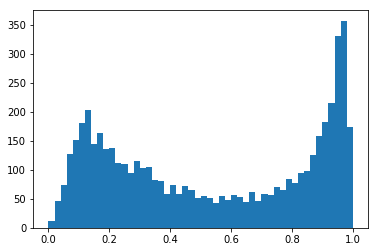

In [629]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

_ = plt.hist(submission1['pred'].values, bins = 50)

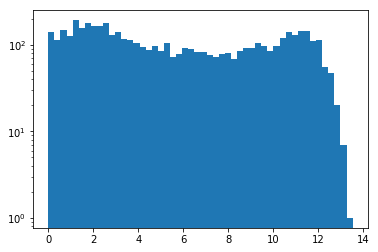

In [625]:
_ = plt.hist(np.log(1 + submission2['pred'].values), bins = 50, log = True)


In [334]:

#submission1.to_csv('task1.csv', index = False)
submission2.to_csv('task2.csv', index = False)